## Tutorial on the basic usage of `qf`

In [1]:
import qf.cc
import qf.graphs
import qf.morph
import qf.qastar
import qf.qzss
import qf.util

In the `examples` directory there is a small graph representing the forward circuits in [*C. elegans*](https://en.wikipedia.org/wiki/Caenorhabditis_elegans) locomotion. 
Here is a small snippet of how the file looks like (this is the so-called *sparse* graph format; the library also allows for an alternative *dense* format, see the API documentation for details).

In [2]:
!head examples/graph.tsv

In the current implementation, weights are ignored. If available, it is convenient to associate to the nodes a position
that is used when visualizing the network (otherwise, the layout will be forced using some standard algorithm). 
Here is how a coordinate file looks like:

In [3]:
!head examples/coordinates.txt

ID x y
PVCL 0.20492990246102952 0.38904538297008134
PVCR 0.821162664221713 0.3884954177072364
VB11 0.18578607086646964 0.8516677131901752
AVBL 0.20321179505072312 0.13166037592335944
AVBR 0.8232335352901196 0.13095097734108677
RIBL 0.2059375431400424 0.0
DB02 1.0 0.4708813535450987
DB03 0.8961887813790183 0.6592014193320896
DB04 0.9406869074245455 0.5762517466586051


We read in the graph and coordinates. The graph is a [`networkx.MultiDiGraph`](https://networkx.org/documentation/stable/reference/classes/multidigraph.html) object, and coordinates (if present) are stored
as suitable node attributes.

In [4]:
G = qf.util.readGraph("examples/graph.tsv", coordinates=qf.util.readCoordinates("examples/coordinates.txt"))

Let us visualize the graph G:

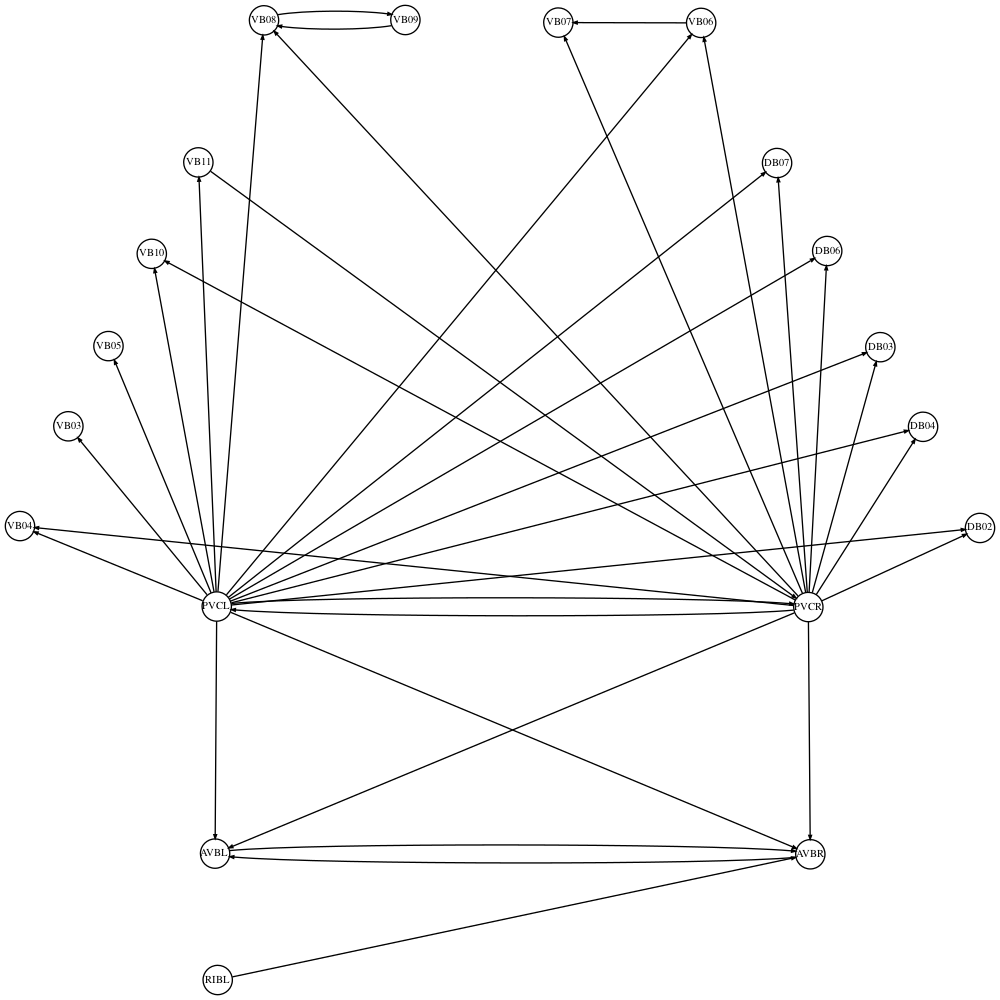

In [5]:
qf.graphs.visualize(G)

Let us now build the Cardon-Crochemore equivalence relation on `G`.

In [6]:
cc = qf.cc.cardon_crochemore(G)

Equivalence relations are usually represented as dictionaries, whose keys are the graph nodes and whose values are the classes (or clusters).
The actual values are not important: the only relevant thing is whether two nodes have the same value (i.e., are in the 
same cluster) or not. Here are the clusters of Cardon-Crochemore.

In [7]:
print(cc)

{'AVBL': 2, 'AVBR': 6, 'PVCL': 5, 'PVCR': 4, 'RIBL': 0, 'DB02': 1, 'DB03': 1, 'DB04': 1, 'DB06': 1, 'DB07': 1, 'VB05': 9, 'VB10': 1, 'VB03': 9, 'VB04': 1, 'VB06': 1, 'VB08': 3, 'VB11': 9, 'VB07': 7, 'VB09': 8}


We can use this dictionary to colour the graph, as follows:

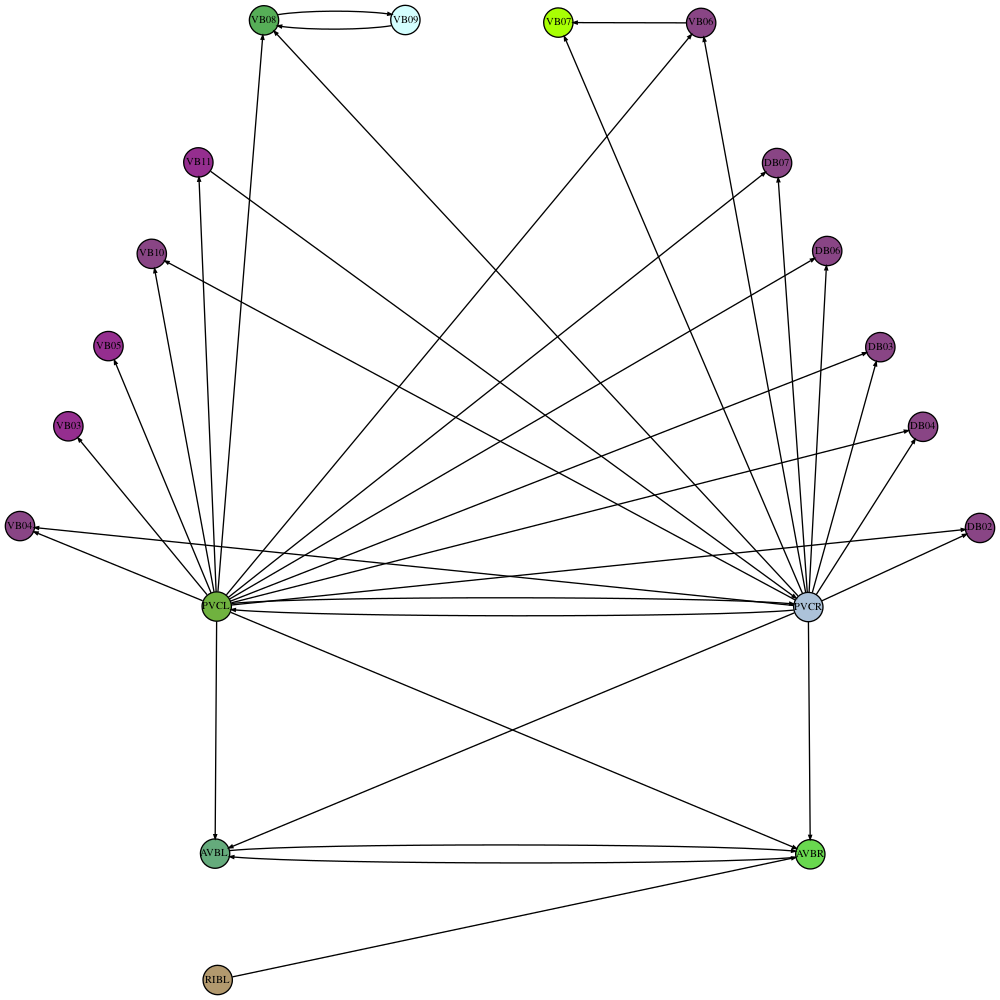

In [8]:
qf.graphs.visualize(G, cc)

In the case of this dataset, we have an idea of how nodes should be clustered. This knowledge (that we shall hereafter
call *ground truth*) is stored in a file, and we can conveniently read it as follows:

In [9]:
gt = qf.util.readLabel("examples/ground-truth.tsv")

If we want to compare two equivalence relations we can use the [adjusted Normalized Mutual Information (NMI)](https://en.wikipedia.org/wiki/Adjusted_mutual_information) score:

In [10]:
print(qf.util.nmi(cc, gt))

0.5431911530687387


Let us consider the matrix of Ordered Edit Distance between the views of nodes truncated at a certain depth (here we use 4). The function that does so also conveniently returns the list of nodes (to have a map from row/column numbers to nodes) and a dictionary (to have the reverse map).

In [11]:
depth = 4
OEDM, nodes, indices = qf.qzss.cachedZssDistMatrix(G, depth)

Here is, for instance, the OED between two nodes.

In [12]:
print(OEDM[indices["AVBL"], indices["AVBR"]])

4.0


We can also compute the Unordered Edit Distance matrix, at the same depth. Since this computation takes worst-case exponential
time, we can specify a time-out and that when the computation of a given entry has been timed out one should use the OEDM
matrix instead.

In [13]:
UEDM, nodes, indices = qf.qastar.qastarDistMatrix(G, depth, Msubs=OEDM, max_milliseconds=60*1000)

18/05/2021 16:00:40 [qastarDistMatrix, line   95]: uted_aster stopped, substituted with 20.0
18/05/2021 16:00:46 [qastarDistMatrix, line   95]: uted_aster stopped, substituted with 10.0
18/05/2021 16:00:47 [qastarDistMatrix, line   95]: uted_aster stopped, substituted with 11.0
18/05/2021 16:00:47 [qastarDistMatrix, line  102]: Stopped 1.75% of the times


Here is the UED between the same two nodes.

In [14]:
print(UEDM[indices["AVBL"], indices["AVBR"]])

3.0


We now perform agglomerative clustering using the matrix UEDM just computed. We have to specify the minimum (4) and maximum
(`G.number_of_nodes()`) numbers of clusters to be used. The function will optimize based on the [Silhouette Coefficient](https://en.wikipedia.org/wiki/Silhouette_(clustering)).
The resulting clustering is turned into a standard dictionary by the second function.

In [15]:
c, _, _, _ = qf.qastar.agclustOptcl(G, depth, 4, G.number_of_nodes(), M=UEDM)
agglc = qf.qastar.agclust2dict(c, UEDM, nodes, indices)

Here is the clustering, its NMI and its visualization as colouring.

In [16]:
print(agglc)
print(qf.util.nmi(agglc, gt))

{'AVBL': 0, 'AVBR': 0, 'PVCL': 7, 'PVCR': 8, 'RIBL': 5, 'DB02': 3, 'DB03': 3, 'DB04': 3, 'DB06': 3, 'DB07': 3, 'VB05': 1, 'VB10': 3, 'VB03': 1, 'VB04': 3, 'VB06': 3, 'VB08': 6, 'VB11': 1, 'VB07': 2, 'VB09': 4}
0.5938505821242617


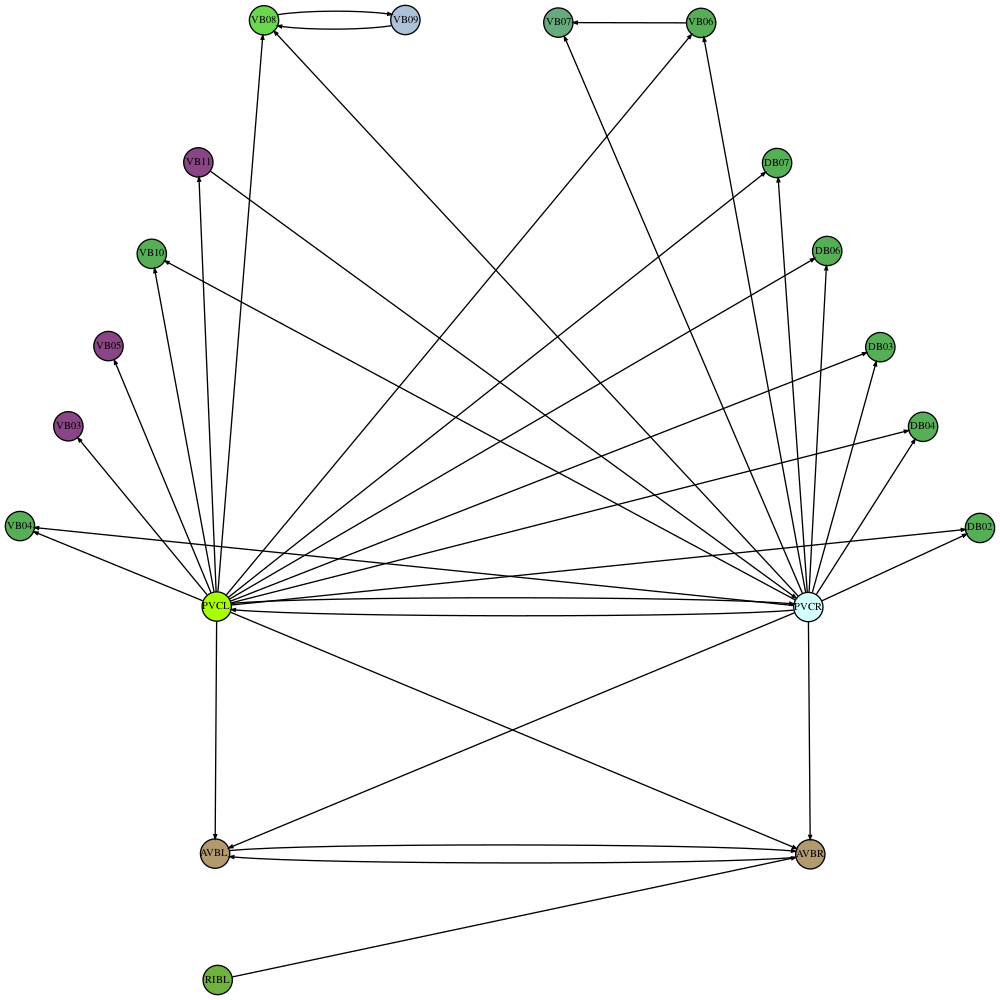

In [17]:
qf.graphs.visualize(G, agglc)

Now we compute the optimal quasi-fibration from G with this equivalence classes as node fibres. The function returns the base graph and the fibration.

In [21]:
B, f = qf.morph.qf_build(G, agglc)

Here is the excess and deficiency of this quasi-fibration.

In [24]:
print(qf.morph.excess_deficiency(f, G, B))

(0, 1)


Now, we show how to repair G so that f is transformed into a fibration. The function returns the new repaired graph and
the new morphism (an epimorphism).

In [27]:
Gp, fp = qf.morph.repair(f, G, B, verbose=True)

Adding arc new_arc_906691059: RIBL -> AVBL (mapped to 5_0_0)


As a final step, we take the repaired graph Gp and perform the Cardon-Crochemore algorithm on it. This step can further improve the clustering.

In [29]:
reduced_agglc = qf.cc.cardon_crochemore(Gp)

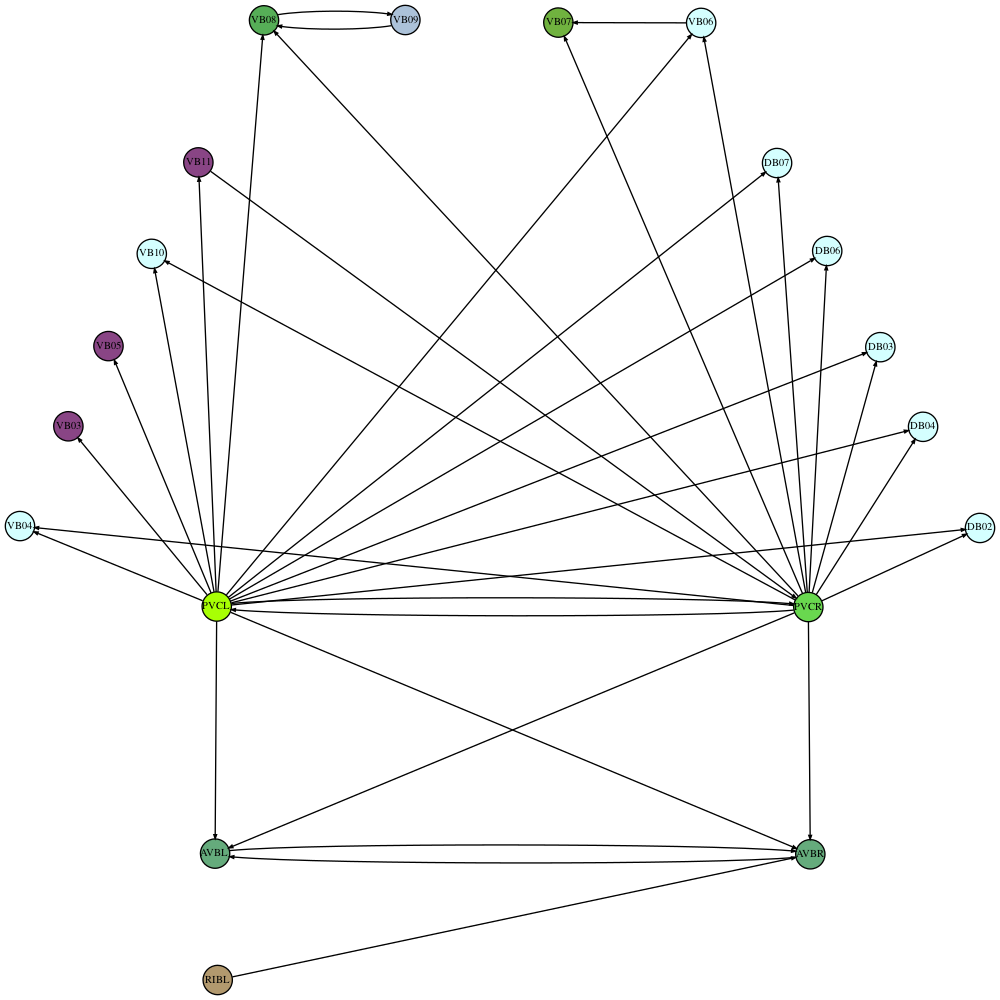

In [32]:
qf.graphs.visualize(G, reduced_agglc)